# Laboratorio 2 (ISIS-2611) — Preparación y limpieza base de datos

Este notebook deja **todo listo** para arrancar el Laboratorio 2 (búsqueda de hiperparámetros, complejidad, validación cruzada, bootstrapping), siguiendo el estilo de las **Prácticas** del repositorio:

- Pipelines con `Pipeline` + `ColumnTransformer`
- Imputación y escalamiento *dentro* del pipeline (evita leakage)
- Separación clara: **limpieza determinística** vs **transformaciones aprendidas**

> **Qué hace este notebook**
> 1) Carga train/test del Lab 1 desde el repositorio (auto-detección de rutas)  
> 2) Limpieza base (determinística): normaliza strings, parsea Blood Pressure, convierte numéricos, elimina nulos del target, quita duplicados exactos  
> 3) Prepara `X_train`, `y_train`, `X_test` (sin leakage)  
> 4) Guarda versiones `processed/` (opcional)  
> 5) Hace un **sanity check** con un modelo baseline (LinearRegression + preprocesamiento)

--- 


In [164]:
# 0) Imports y configuración


import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score



## 1) Localizar y cargar los datos (auto-detección)

El repositorio suele tener los datos en:

- `Laboratorios/L1 Regresion Lineal/data/Datos Lab 1.csv`
- `Laboratorios/L1 Regresion Lineal/data/Datos Test Lab 1.csv`

Como a veces el notebook corre desde otra carpeta (p.ej. Lab 2), hacemos una función que busca esos archivos hacia arriba en el árbol de directorios.


In [165]:


train = "./data/Datos Lab 1.csv"
test = "./data/Datos Test Lab 1.csv"

print("Train:", train)
print("Test :", test)

df_train_raw = pd.read_csv(train)
df_test_raw = pd.read_csv(test, sep=";")

print("\nShapes raw:")
print("df_train_raw:", df_train_raw.shape)
print("df_test_raw :", df_test_raw.shape)

df_train_raw.head(3)


Train: ./data/Datos Lab 1.csv
Test : ./data/Datos Test Lab 1.csv

Shapes raw:
df_train_raw: (1639, 24)
df_test_raw : (194, 22)


,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
0,isDx5313,"November 08, 2023",M,44.0,114.300,1.720,38.600,100.000,112/83,228.0,...,High,N,172.000,0.581,112.0,83.0,Hypertension Stage 1,121.0,19.880,HIGH
1,LHCK2961,20/03/2024,F,57.0,92.923,1.842,33.116,106.315,101/91,158.0,...,High,Y,184.172,0.577,101.0,91.0,Hypertension Stage 2,57.0,16.833,INTERMEDIARY
2,WjVn1699,2021-05-27,F,NaN,73.400,1.650,27.000,78.100,90/74,135.0,...,High,N,165.000,0.473,90.0,74.0,Normal,45.0,12.600,LOW


## 2) Checklist rápido de calidad (antes de limpiar)

Solo para tener una foto rápida (completitud + duplicados).


In [166]:
def missing_report(df: pd.DataFrame) -> pd.DataFrame:
    out = pd.DataFrame({
        "n_null": df.isna().sum(),
        "%_null": (df.isna().mean() * 100).round(2),
        "dtype": df.dtypes.astype(str),
    }).sort_values("%_null", ascending=False)
    return out

print("Duplicados exactos (train):", df_train_raw.duplicated().sum())
print("Patient ID duplicados (train):", df_train_raw["Patient ID"].duplicated().sum() if "Patient ID" in df_train_raw.columns else "N/A")

missing_report(df_train_raw).head(12)


Duplicados exactos (train): 151
Patient ID duplicados (train): 263


,n_null,%_null,dtype
Diastolic BP,85,5.19,float64
HDL (mg/dL),82,5.00,float64
Waist-to-Height Ratio,76,4.64,float64
Weight (kg),73,4.45,float64
Total Cholesterol (mg/dL),68,4.15,float64
Age,68,4.15,float64
Height (cm),68,4.15,float64
Height (m),61,3.72,float64
Abdominal Circumference (cm),61,3.72,float64
Systolic BP,61,3.72,float64


## 3) Limpieza base (determinística)

Objetivo: **dejar el dataset consistente** sin meter lógica “aprendida” (imputación/escalado) por fuera del pipeline.

### Reglas que aplicamos
- Normalización de strings: `strip()` + `upper()` en columnas categóricas
- Parse de `Blood Pressure (mmHg)` si viene como `"120/80"`  
  - Se usa para completar `Systolic BP` y `Diastolic BP` cuando falten
- Conversión robusta a numérico en columnas numéricas (con `errors='coerce'`)
- Eliminación de filas con `CVD Risk Score` nulo en train (target)
- Eliminación de duplicados exactos (filas idénticas)

> **Importante:** No imputamos aquí. Eso se hace en los pipelines del Lab 2 (como en las Prácticas).


In [167]:
TARGET = "CVD Risk Score"

CATEGORICAL_COLS = [
    "Sex",
    "Smoking Status",
    "Diabetes Status",
    "Physical Activity Level",
    "Family History of CVD",
    "Blood Pressure Category",
]

NUMERIC_COLS = [
    "Age",
    "Weight (kg)",
    "Height (m)",
    "BMI",
    "Abdominal Circumference (cm)",
    "Total Cholesterol (mg/dL)",
    "HDL (mg/dL)",
    "Fasting Blood Sugar (mg/dL)",
    "Height (cm)",
    "Waist-to-Height Ratio",
    "Systolic BP",
    "Diastolic BP",
    "Estimated LDL (mg/dL)",
]

def normalize_strings(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    df = df.copy()
    for c in cols:
        if c in df.columns:
            df[c] = (
                df[c]
                .astype("string")
                .str.strip()
                .str.upper()
                .str.replace(r"\s+", " ", regex=True)
            )
    return df

def parse_bp(df: pd.DataFrame, bp_col: str = "Blood Pressure (mmHg)") -> pd.DataFrame:
    """Extrae sistólica/diastólica desde '120/80' cuando exista."""
    df = df.copy()
    if bp_col not in df.columns:
        return df

    s = df[bp_col].astype("string")
    # Extrae números tipo 120/80 (permite espacios)
    extracted = s.str.extract(r"(?P<sys>\d{2,3})\s*/\s*(?P<dia>\d{2,3})")
    df["Systolic BP_parsed"] = pd.to_numeric(extracted["sys"], errors="coerce")
    df["Diastolic BP_parsed"] = pd.to_numeric(extracted["dia"], errors="coerce")
    return df

def merge_bp(df: pd.DataFrame) -> pd.DataFrame:
    """Completa Systolic/Diastolic con los *_parsed cuando falten."""
    df = df.copy()
    for base, parsed in [("Systolic BP", "Systolic BP_parsed"), ("Diastolic BP", "Diastolic BP_parsed")]:
        if base in df.columns and parsed in df.columns:
            df[base] = pd.to_numeric(df[base], errors="coerce")
            df[base] = df[base].fillna(df[parsed])
    return df

def coerce_numeric(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    df = df.copy()
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df
def filter_valid_target_range(df: pd.DataFrame, target_col: str = TARGET, min_value: float = 0.0, max_value: float = 1000.0) -> pd.DataFrame:
    """
    Conserva únicamente filas cuyo target esté en el rango [min_value, max_value].
    Asume que el target ya fue convertido a numérico.
    """
    df = df.copy()

    if target_col not in df.columns:
        return df

    mask_valid = df[target_col].between(min_value, max_value, inclusive="both")
    return df.loc[mask_valid].copy()


def base_clean_train_test(df_train: pd.DataFrame, df_test: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    # 1) Normalizar categóricas (consistencia)
    df_train = normalize_strings(df_train, CATEGORICAL_COLS + ["CVD Risk Level"])
    df_test  = normalize_strings(df_test,  CATEGORICAL_COLS)

    # 2) Parse/merge Blood Pressure
    df_train = merge_bp(parse_bp(df_train))
    df_test  = merge_bp(parse_bp(df_test))

    # 3) Coerción numérica
    df_train = coerce_numeric(df_train, NUMERIC_COLS + [TARGET])
    df_test  = coerce_numeric(df_test,  NUMERIC_COLS)

    # 4) Completitud: remover nulos en el target (solo train)
    if TARGET in df_train.columns:
        df_train = df_train.dropna(subset=[TARGET])

    # 5) Validez: conservar solo targets en rango [0, 100]
    if TARGET in df_train.columns:
        df_train = filter_valid_target_range(df_train, target_col=TARGET, min_value=0.0, max_value=1000.0)

    # 6) Duplicados exactos
    df_train = df_train.drop_duplicates()
    df_test  = df_test.drop_duplicates()

    return df_train, df_test

df_train_clean, df_test_clean = base_clean_train_test(df_train_raw, df_test_raw)

print("Shapes clean:")
print("df_train_clean:", df_train_clean.shape)
print("df_test_clean :", df_test_clean.shape)

df_train_clean.head(3)


Shapes clean:
df_train_clean: (1451, 26)
df_test_clean : (189, 24)


,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level,Systolic BP_parsed,Diastolic BP_parsed
0,isDx5313,"November 08, 2023",M,44.0,114.300,1.720,38.600,100.000,112/83,228.0,...,172.000,0.581,112.0,83.0,HYPERTENSION STAGE 1,121.0,19.880,HIGH,112,83
1,LHCK2961,20/03/2024,F,57.0,92.923,1.842,33.116,106.315,101/91,158.0,...,184.172,0.577,101.0,91.0,HYPERTENSION STAGE 2,57.0,16.833,INTERMEDIARY,101,91
2,WjVn1699,2021-05-27,F,NaN,73.400,1.650,27.000,78.100,90/74,135.0,...,165.000,0.473,90.0,74.0,NORMAL,45.0,12.600,LOW,90,74


## 4) Preparar `X_train`, `y_train`, `X_test` (sin leakage)

- Se elimina `CVD Risk Level` **por defecto** (es derivada del target; mejor no tocarla en Lab 2)
- Se eliminan identificadores y fecha (a menos que el profe explícitamente pida ingeniería de features temporal)

Si necesitas *conservar* algo para análisis, hazlo en una copia, pero **no lo metas al pipeline** por accidente.


In [168]:
DROP_ALWAYS = ["Patient ID", "Date of Service", "CVD Risk Level", "Blood Pressure (mmHg)", "Systolic BP_parsed", "Diastolic BP_parsed"]

X_train = df_train_clean.drop(columns=DROP_ALWAYS + [TARGET], errors="ignore")
y_train = df_train_clean[TARGET].astype(float)

X_test  = df_test_clean.drop(columns=DROP_ALWAYS, errors="ignore")

print("X_train:", X_train.shape, "| y_train:", y_train.shape)
print("X_test :", X_test.shape)

# Checks rápidos
assert set(X_train.columns) == set(X_test.columns), "Train/test no tienen las mismas columnas"
print("✅ Mismas columnas en train y test")

X_train.isna().mean().sort_values(ascending=False).head(10)


X_train: (1451, 19) | y_train: (1451,)
X_test : (189, 19)
✅ Mismas columnas en train y test


HDL (mg/dL)                     0.050310
Waist-to-Height Ratio           0.046175
Weight (kg)                     0.045486
Total Cholesterol (mg/dL)       0.042040
Age                             0.041351
Height (cm)                     0.041351
Height (m)                      0.036527
Estimated LDL (mg/dL)           0.035148
Abdominal Circumference (cm)    0.033770
Fasting Blood Sugar (mg/dL)     0.033081
dtype: float64

## 5) Guardar versiones `processed/` (opcional)

Esto te sirve para que el notebook principal del Lab 2 sea más corto:
- Cargas `X_train.csv`, `y_train.csv`, `X_test.csv`
- Construyes pipelines + GridSearchCV encima

> Si no quieres guardar nada, puedes saltarte esta sección.


In [169]:
from pathlib import Path


PROCESSED_DIR = Path.cwd() / "data" / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

(df_train_clean).to_csv(PROCESSED_DIR / "train_clean_base.csv", index=False)
(df_test_clean ).to_csv(PROCESSED_DIR / "test_clean_base.csv", index=False)

X_train.to_csv(PROCESSED_DIR / "X_train.csv", index=False)
y_train.to_csv(PROCESSED_DIR / "y_train.csv", index=False)
X_test.to_csv(PROCESSED_DIR / "X_test.csv", index=False)

print("Guardado en:", PROCESSED_DIR.resolve())


Guardado en: C:\Users\userr\MaterialDeClase-ISIS-2611\Laboratorios\L2 Complejidad y búsqueda de hiperparámetros\data\processed


In [170]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 1) Preparar columnas
# =========================
df_plot = df_train_clean.copy()

# Columnas que no tiene sentido graficar como distribución
exclude_cols = [
    "Patient ID",
    "Date of Service",
    "Blood Pressure (mmHg)",
    "Systolic BP_parsed",
    "Diastolic BP_parsed"
]

df_plot = df_plot.drop(columns=exclude_cols, errors="ignore")

# Separar numéricas y categóricas
numeric_cols = df_plot.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_plot.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numéricas:", numeric_cols)
print("Categóricas:", categorical_cols)


Numéricas: ['Age', 'Weight (kg)', 'Height (m)', 'BMI', 'Abdominal Circumference (cm)', 'Total Cholesterol (mg/dL)', 'HDL (mg/dL)', 'Fasting Blood Sugar (mg/dL)', 'Height (cm)', 'Waist-to-Height Ratio', 'Systolic BP', 'Diastolic BP', 'Estimated LDL (mg/dL)', 'CVD Risk Score']
Categóricas: ['Sex', 'Smoking Status', 'Diabetes Status', 'Physical Activity Level', 'Family History of CVD', 'Blood Pressure Category', 'CVD Risk Level']


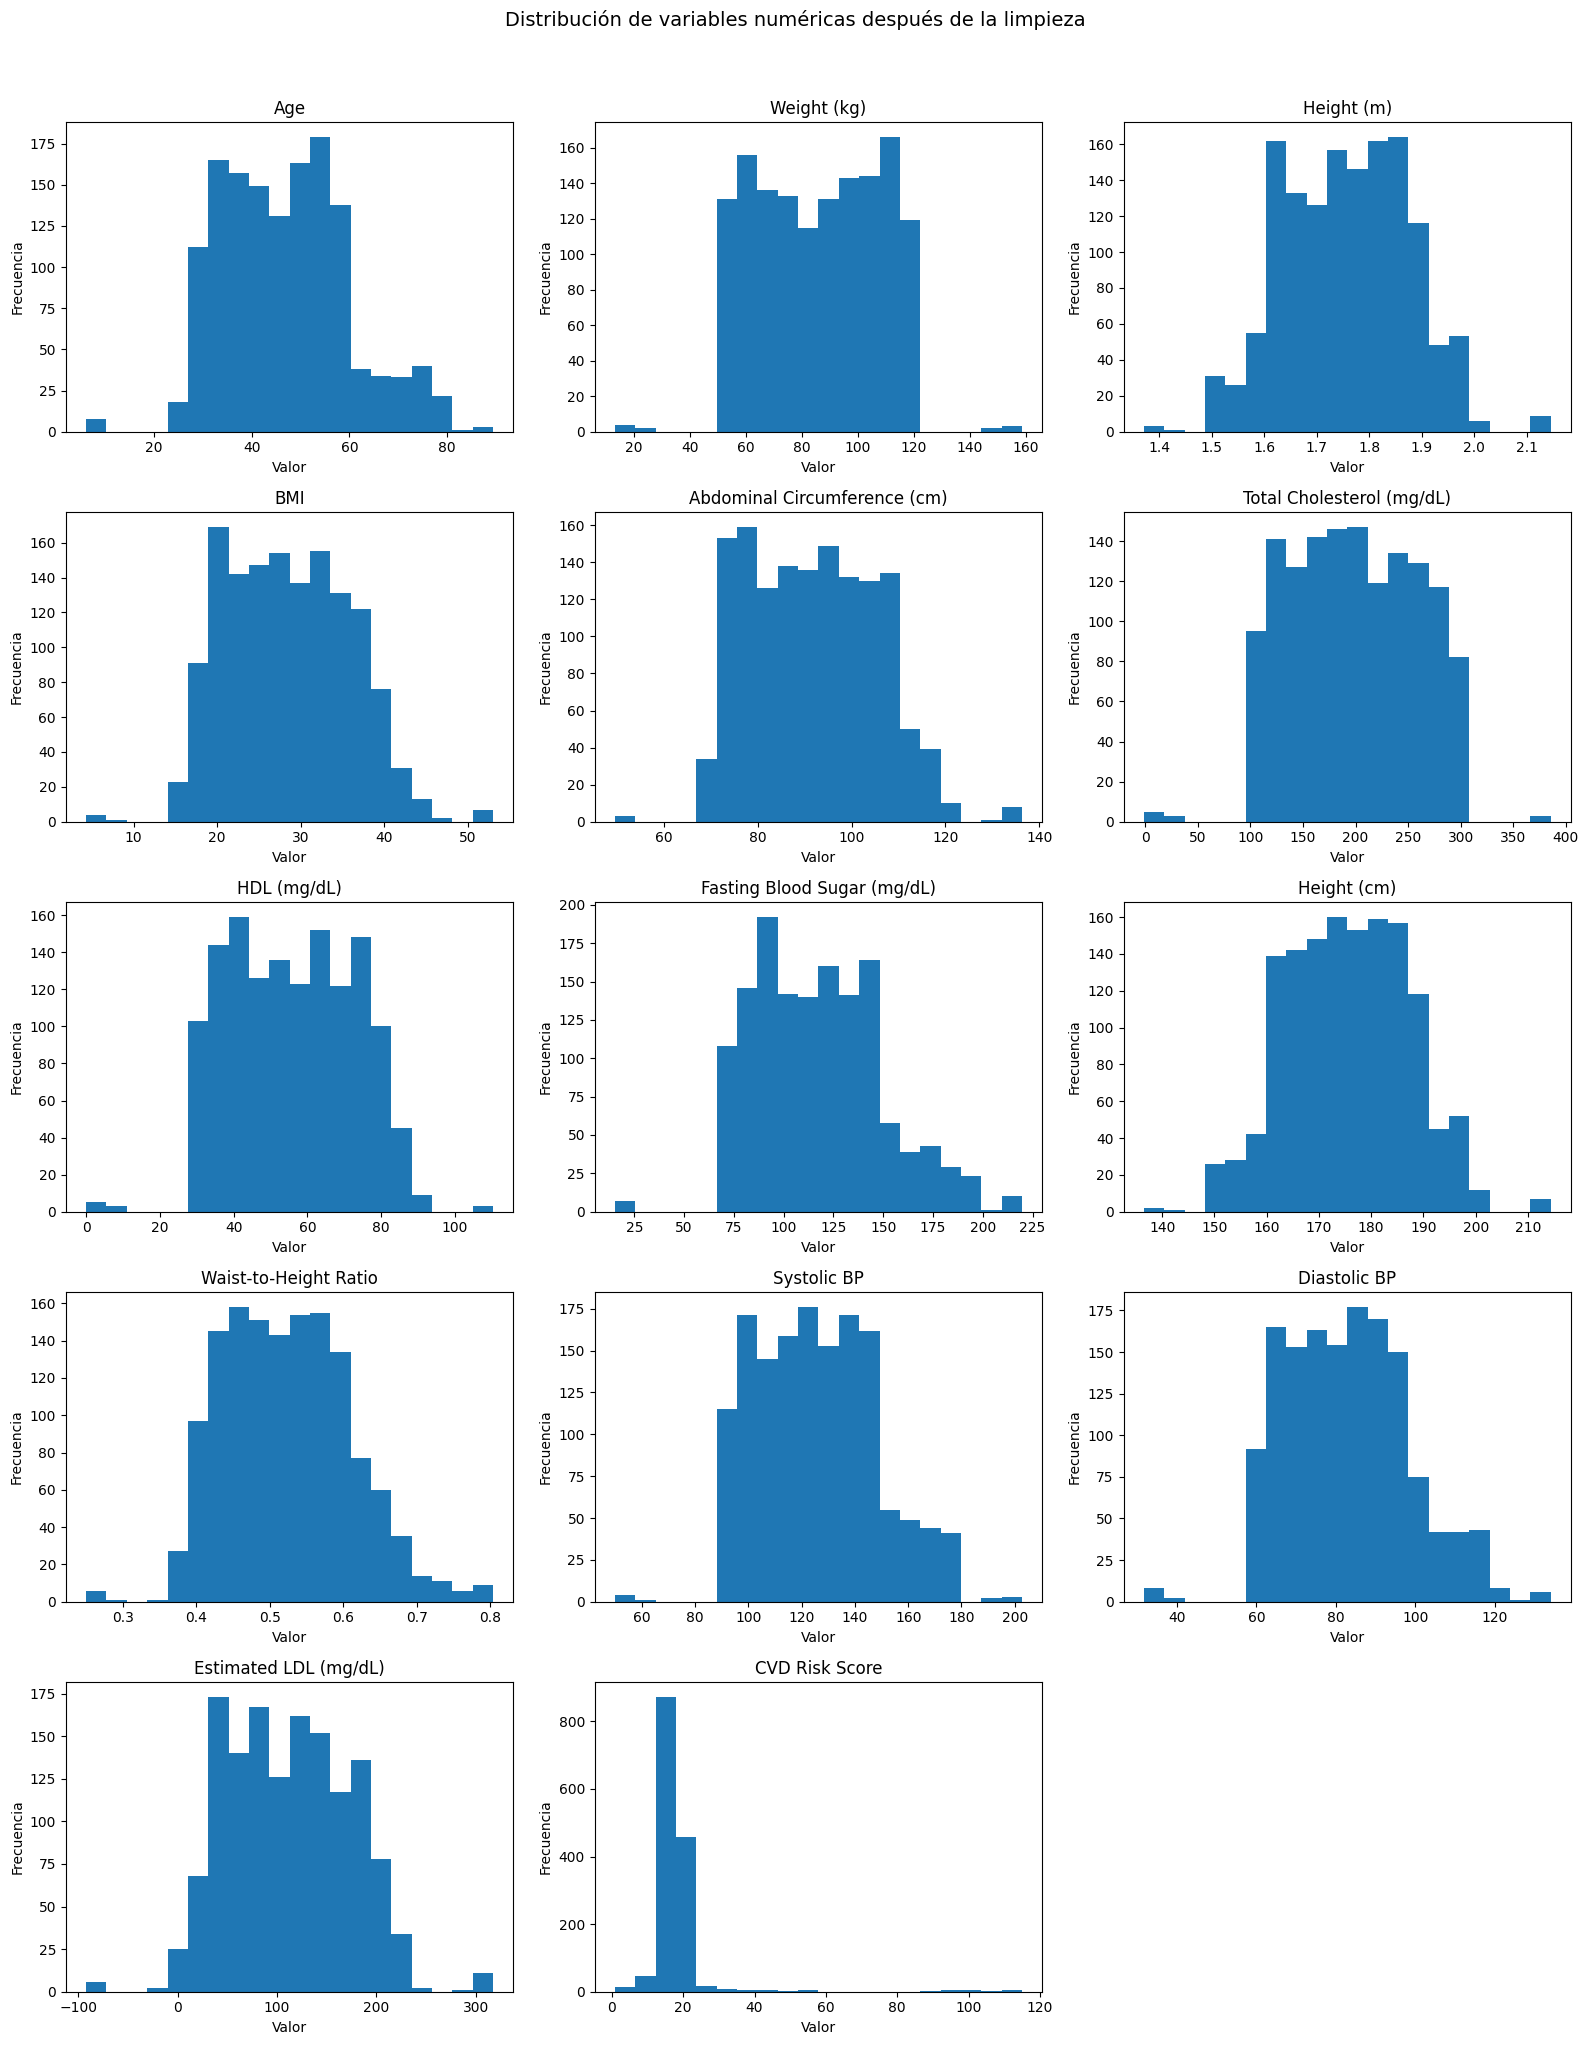

In [171]:
# =========================
# 2) Histogramas numéricos
# =========================
if len(numeric_cols) > 0:
    n = len(numeric_cols)
    ncols = 3
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4 * nrows))
    axes = np.array(axes).reshape(-1)

    for i, col in enumerate(numeric_cols):
        ax = axes[i]
        data = pd.to_numeric(df_plot[col], errors="coerce").dropna()

        ax.hist(data, bins=20)
        ax.set_title(col)
        ax.set_xlabel("Valor")
        ax.set_ylabel("Frecuencia")

    # Apagar ejes sobrantes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.suptitle("Distribución de variables numéricas después de la limpieza", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("No hay columnas numéricas para graficar.")

## Listo ✅

A partir de aquí, en tu notebook principal del Lab 2 puedes:

1) Cargar `X_train`, `y_train` y construir los pipelines con `GridSearchCV`  
2) Generar curvas de validación (grado del polinomio vs error CV)  
3) Comparar modelos (sin regularización, Ridge, Lasso, polinomial+regularización)  
4) Seleccionar el mejor por **promedio** y **desviación estándar** en CV  
5) Bootstrapping en tu conjunto de test (≥ 500 remuestreos) para intervalos de confianza

--- 

Si quieres, te puedo generar el notebook completo del Lab 2 encima de estas mismas variables (con las 7 actividades).


Inicio del laboratorio 2

1. Se construye el modelo de regresión polinomial, justificando las decisiones tomadas.

In [172]:

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



# ---- (A) Cargar data procesada (si aplica) ----
X_train = pd.read_csv("data/processed/X_train.csv")
y_train = pd.read_csv("data/processed/y_train.csv").squeeze()

# ---- (B) Identificar columnas numéricas y categóricas ----
# Si ya tienes listas (NUMERIC_COLS, CATEGORICAL_COLS) úsalo. Si no:
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numéricas:", numeric_features)
print("Categóricas:", categorical_features)

# ---- (C) Transformers ----
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("poly", PolynomialFeatures(degree=2)),
    ("scaler", StandardScaler()),
])

# Compatibilidad sklearn: sparse_output (nuevo) vs sparse (viejo)

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

# ---- (D) Modelo polinomial completo ----
poly_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression()),
])

# ---- (E) Sanity check con hold-out (solo para verificar que corre) ----
X_tr, X_te, y_tr, y_te = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE
)

poly_model.fit(X_tr, y_tr)
pred = poly_model.predict(X_te)

rmse = root_mean_squared_error(y_te, pred)
mae  = mean_absolute_error(y_te, pred)
r2   = r2_score(y_te, pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

Numéricas: ['Age', 'Weight (kg)', 'Height (m)', 'BMI', 'Abdominal Circumference (cm)', 'Total Cholesterol (mg/dL)', 'HDL (mg/dL)', 'Fasting Blood Sugar (mg/dL)', 'Height (cm)', 'Waist-to-Height Ratio', 'Systolic BP', 'Diastolic BP', 'Estimated LDL (mg/dL)']
Categóricas: ['Sex', 'Smoking Status', 'Diabetes Status', 'Physical Activity Level', 'Family History of CVD', 'Blood Pressure Category']
RMSE: 12.0014
MAE : 5.2358
R²  : -0.2065


In [173]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



# ---- (A) Cargar data procesada (si aplica) ----
X_train = pd.read_csv("data/processed/X_train.csv")
y_train = pd.read_csv("data/processed/y_train.csv").squeeze()

# ---- (B) Identificar columnas numéricas y categóricas ----
# Si ya tienes listas (NUMERIC_COLS, CATEGORICAL_COLS) úsalo. Si no:
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numéricas:", numeric_features)
print("Categóricas:", categorical_features)

# ---- (C) Transformers ----
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("poly", PolynomialFeatures(degree=2)),
    ("scaler", StandardScaler()),
])

# Compatibilidad sklearn: sparse_output (nuevo) vs sparse (viejo)

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

# ---- (D) Modelo polinomial completo ----
poly_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression()),
])

# ---- (E) Sanity check con hold-out (solo para verificar que corre) ----
X_tr, X_te, y_tr, y_te = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE
)

poly_model.fit(X_tr, y_tr)
pred = poly_model.predict(X_te)

rmse = root_mean_squared_error(y_te, pred)
mae  = mean_absolute_error(y_te, pred)
r2   = r2_score(y_te, pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

Numéricas: ['Age', 'Weight (kg)', 'Height (m)', 'BMI', 'Abdominal Circumference (cm)', 'Total Cholesterol (mg/dL)', 'HDL (mg/dL)', 'Fasting Blood Sugar (mg/dL)', 'Height (cm)', 'Waist-to-Height Ratio', 'Systolic BP', 'Diastolic BP', 'Estimated LDL (mg/dL)']
Categóricas: ['Sex', 'Smoking Status', 'Diabetes Status', 'Physical Activity Level', 'Family History of CVD', 'Blood Pressure Category']
RMSE: 12.0014
MAE : 5.2358
R²  : -0.2065


Un analisis rapido que se puede ver es que cuando el grado del polinomio agranda el modelo tiende a ser menor preciso dandonos cuenta a traves del RMSE y R cuadrado especificamente

Modelo Ridge

In [174]:
try:
    ohe = OneHotEncoder(handle_unknown="ignore", drop="if_binary", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", drop="if_binary", sparse=False)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe)
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

pipeline_ridge = Pipeline(steps=[
    ("preprocesamiento", preprocessor),
    ("modelo", Ridge())
])


param_grid_ridge = {
    "preprocesamiento__num__scaler": [StandardScaler(), MinMaxScaler()],
    "modelo__alpha": np.logspace(-3, 3, 13)
}

kfold = KFold(n_splits=10, shuffle=True, random_state=1)

grid_ridge = GridSearchCV(
    estimator=pipeline_ridge,
    param_grid=param_grid_ridge,
    cv=kfold,
    scoring="r2",
    n_jobs=-1
)

grid_ridge.fit(X_tr, y_tr)

best_ridge = grid_ridge.best_estimator_

print("Mejores parámetros Ridge:", grid_ridge.best_params_)
print("Mejor R² en validación cruzada:", grid_ridge.best_score_)

Mejores parámetros Ridge: {'modelo__alpha': np.float64(316.22776601683796), 'preprocesamiento__num__scaler': StandardScaler()}
Mejor R² en validación cruzada: 0.03501526345720979


In [175]:
y_pred_ridge_train = best_ridge.predict(X_tr)
y_pred_ridge_test = best_ridge.predict(X_te)

rmse_ridge_train = np.sqrt(root_mean_squared_error(y_tr, y_pred_ridge_train))
mae_ridge_train = mean_absolute_error(y_tr, y_pred_ridge_train)
r2_ridge_train = r2_score(y_tr, y_pred_ridge_train)

rmse_ridge_test = np.sqrt(root_mean_squared_error(y_te, y_pred_ridge_test))
mae_ridge_test = mean_absolute_error(y_te, y_pred_ridge_test)
r2_ridge_test = r2_score(y_te, y_pred_ridge_test)

print("=== RIDGE ===")
print("TRAIN")
print(f"RMSE: {rmse_ridge_train:.4f}")
print(f"MAE : {mae_ridge_train:.4f}")
print(f"R²  : {r2_ridge_train:.4f}")

print("\nTEST")
print(f"RMSE: {rmse_ridge_test:.4f}")
print(f"MAE : {mae_ridge_test:.4f}")
print(f"R²  : {r2_ridge_test:.4f}")

=== RIDGE ===
TRAIN
RMSE: 3.1973
MAE : 3.3383
R²  : 0.0536

TEST
RMSE: 3.2835
MAE : 3.3403
R²  : 0.0263


Vamos a ver los valores de las coeficientes para ver cual es el que más afecta


In [176]:
preproc_fitted_ridge = best_ridge.named_steps["preprocesamiento"]
feature_names_ridge = preproc_fitted_ridge.get_feature_names_out()
coefs_ridge = best_ridge.named_steps["modelo"].coef_

coef_ridge_df = pd.DataFrame({
    "Característica": feature_names_ridge,
    "coef_ridge": coefs_ridge
})

# Quitar el prefijo que agrega ColumnTransformer (num__ / cat__ / etc.)
coef_ridge_df["Característica"] = coef_ridge_df["Característica"].str.split("__").str[-1]

# Redondear para que quede más legible
coef_ridge_df["coef_ridge"] = coef_ridge_df["coef_ridge"].round(3)

# Ordenar por magnitud absoluta del coeficiente
coef_ridge_df_sorted = coef_ridge_df.sort_values(
    "coef_ridge", key=abs, ascending=False
)

coef_ridge_df_sorted

,Característica,coef_ridge
15,Diabetes Status_Y,1.282
3,BMI,1.187
23,Blood Pressure Category_NORMAL,-0.699
10,Systolic BP,0.592
19,Family History of CVD_Y,-0.513
17,Physical Activity Level_LOW,-0.495
18,Physical Activity Level_MODERATE,0.452
21,Blood Pressure Category_HYPERTENSION STAGE 1,0.400
5,Total Cholesterol (mg/dL),0.346
20,Blood Pressure Category_ELEVATED,0.330


Los coeficientes obtenidos con Ridge presentan magnitudes moderadas y signos mixtos, lo cual es esperable bajo regularización L2. Se observa mayor peso en variables clínicamente relevantes como diabetes, IMC y presión sistólica. Sin embargo, la interpretación individual de algunos coeficientes debe hacerse con cautela debido a la presencia de multicolinealidad entre variables como altura, peso e IMC, situación que Ridge atenúa, aunque no elimina completamente.

Modelo Lasso

In [177]:
try:
    ohe = OneHotEncoder(handle_unknown="ignore", drop="if_binary", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", drop="if_binary", sparse=False)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe)
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

pipeline_lasso = Pipeline(steps=[
    ("preprocesamiento", preprocessor),
    ("modelo", Lasso(max_iter=20000))
])


param_grid_lasso = {
    "preprocesamiento__num__scaler": [StandardScaler(), MinMaxScaler()],
    "modelo__alpha": np.logspace(-3, 1, 120)
}

kfold = KFold(n_splits=10, shuffle=True, random_state=1)

grid_lasso = GridSearchCV(
    estimator=pipeline_lasso,
    param_grid=param_grid_lasso,
    cv=kfold,
    scoring="r2",
    n_jobs=-1
)

grid_lasso.fit(X_tr, y_tr)

best_lasso = grid_lasso.best_estimator_

print("Mejores parámetros Lasso:", grid_lasso.best_params_)
print("Mejor R² en validación cruzada:", grid_lasso.best_score_)

Mejores parámetros Lasso: {'modelo__alpha': np.float64(0.2435312073433415), 'preprocesamiento__num__scaler': StandardScaler()}
Mejor R² en validación cruzada: 0.05096119485957212


In [178]:
y_pred_lasso_train = best_lasso.predict(X_tr)
y_pred_lasso_test = best_lasso.predict(X_te)

rmse_lasso_train = np.sqrt(root_mean_squared_error(y_tr, y_pred_lasso_train))
mae_lasso_train = mean_absolute_error(y_tr, y_pred_lasso_train)
r2_lasso_train = r2_score(y_tr, y_pred_lasso_train)

rmse_lasso_test = np.sqrt(root_mean_squared_error(y_te, y_pred_lasso_test))
mae_lasso_test = mean_absolute_error(y_te, y_pred_lasso_test)
r2_lasso_test = r2_score(y_te, y_pred_lasso_test)

print("=== LASSO ===")
print("TRAIN")
print(f"RMSE: {rmse_lasso_train:.4f}")
print(f"MAE : {mae_lasso_train:.4f}")
print(f"R²  : {r2_lasso_train:.4f}")

print("\nTEST")
print(f"RMSE: {rmse_lasso_test:.4f}")
print(f"MAE : {mae_lasso_test:.4f}")
print(f"R²  : {r2_lasso_test:.4f}")

=== LASSO ===
TRAIN
RMSE: 3.2034
MAE : 3.3178
R²  : 0.0463

TEST
RMSE: 3.2731
MAE : 3.2132
R²  : 0.0386


In [179]:
preproc_fitted_lasso = best_lasso.named_steps["preprocesamiento"]
feature_names_lasso = preproc_fitted_lasso.get_feature_names_out()
coefs_lasso = best_lasso.named_steps["modelo"].coef_

coef_lasso_df = pd.DataFrame({
    "Característica": feature_names_lasso,
    "coef_lasso": coefs_lasso
})

# Quitar el prefijo que agrega ColumnTransformer (num__ / cat__ / etc.)
coef_lasso_df["Característica"] = coef_lasso_df["Característica"].str.split("__").str[-1]

# Redondear para que quede más legible
coef_lasso_df["coef_lasso"] = coef_lasso_df["coef_lasso"].round(3)

# Ordenar por magnitud absoluta del coeficiente
coef_lasso_df_sorted = coef_lasso_df.sort_values(
    "coef_lasso", key=abs, ascending=False
)

coef_lasso_df_sorted

,Característica,coef_lasso
15,Diabetes Status_Y,1.684
3,BMI,1.166
23,Blood Pressure Category_NORMAL,-0.693
10,Systolic BP,0.534
5,Total Cholesterol (mg/dL),0.222
17,Physical Activity Level_LOW,-0.162
0,Age,-0.111
19,Family History of CVD_Y,-0.086
18,Physical Activity Level_MODERATE,0.050
7,Fasting Blood Sugar (mg/dL),0.000


Regularizacion + Poly


In [188]:
try:
    ohe = OneHotEncoder(handle_unknown="ignore", drop="if_binary", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", drop="if_binary", sparse=False)

# Numéricas: imputar -> polinomios -> escalar
numeric_transformer_poly = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scaler", StandardScaler())
])

# Categóricas: imputar -> one-hot
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe)
])

preprocessor_poly = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_poly, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

kfold = KFold(n_splits=10, shuffle=True, random_state=1)

pipeline_ridge_poly = Pipeline(steps=[
    ("preprocesamiento", preprocessor_poly),
    ("modelo", Ridge())
])

param_grid_ridge_poly = {
    "preprocesamiento__num__poly__degree": [2, 3],
    "preprocesamiento__num__scaler": [StandardScaler(), MinMaxScaler()],
    "modelo__alpha": np.logspace(-3, 3, 13)
}

grid_ridge_poly = GridSearchCV(
    estimator=pipeline_ridge_poly,
    param_grid=param_grid_ridge_poly,
    cv=kfold,
    scoring="r2",
    n_jobs=-1
)

grid_ridge_poly.fit(X_tr, y_tr)

best_ridge_poly = grid_ridge_poly.best_estimator_

print("Mejores parámetros Ridge polinomial:", grid_ridge_poly.best_params_)
print("Mejor R² CV Ridge polinomial:", grid_ridge_poly.best_score_)

Mejores parámetros Ridge polinomial: {'modelo__alpha': np.float64(316.22776601683796), 'preprocesamiento__num__poly__degree': 3, 'preprocesamiento__num__scaler': MinMaxScaler()}
Mejor R² CV Ridge polinomial: 0.03856380022273444


In [ ]:
pipeline_lasso_poly = Pipeline(steps=[
    ("preprocesamiento", preprocessor_poly),
    ("modelo", Lasso(max_iter=5000))
])

param_grid_lasso_poly = {
    "preprocesamiento__num__poly__degree": [2,3],
    "preprocesamiento__num__scaler": [StandardScaler(), MinMaxScaler()],
    "modelo__alpha": np.logspace(-3, 3, 13)
}

grid_lasso_poly = GridSearchCV(
    estimator=pipeline_lasso_poly,
    param_grid=param_grid_lasso_poly,
    cv=kfold,
    scoring="r2",
    n_jobs=-1
)

grid_lasso_poly.fit(X_tr, y_tr)

best_lasso_poly = grid_lasso_poly.best_estimator_

print("Mejores parámetros Lasso polinomial:", grid_lasso_poly.best_params_)
print("Mejor R² CV Lasso polinomial:", grid_lasso_poly.best_score_)

Mejores parámetros Lasso polinomial: {'modelo__alpha': np.float64(0.30718143012686966), 'preprocesamiento__num__poly__degree': 2, 'preprocesamiento__num__scaler': StandardScaler()}
Mejor R² CV Lasso polinomial: 0.05555383013228031


In [189]:
def evaluar_modelo(modelo, X_train_eval, X_test_eval, y_train_eval, y_test_eval):
    y_pred_train = modelo.predict(X_train_eval)
    y_pred_test = modelo.predict(X_test_eval)

    resultados = {
        "RMSE_train": np.sqrt(root_mean_squared_error(y_train_eval, y_pred_train)),
        "MAE_train": mean_absolute_error(y_train_eval, y_pred_train),
        "R2_train": r2_score(y_train_eval, y_pred_train),
        "RMSE_test": np.sqrt(root_mean_squared_error(y_test_eval, y_pred_test)),
        "MAE_test": mean_absolute_error(y_test_eval, y_pred_test),
        "R2_test": r2_score(y_test_eval, y_pred_test),
    }
    return resultados

res_ridge_poly = evaluar_modelo(best_ridge_poly, X_tr, X_te, y_tr, y_te)
res_lasso_poly = evaluar_modelo(best_lasso_poly, X_tr, X_te, y_tr, y_te)

print("Ridge polinomial:", res_ridge_poly)
print("Lasso polinomial:", res_lasso_poly)

Ridge polinomial: {'RMSE_train': np.float64(3.197131189051389), 'MAE_train': 3.322448004172756, 'R2_train': 0.0537657930443729, 'RMSE_test': np.float64(3.283297727785267), 'MAE_test': 3.3293774285427276, 'R2_test': 0.026527488549896505}
Lasso polinomial: {'RMSE_train': np.float64(3.2080165694142524), 'MAE_train': 3.307070225890213, 'R2_train': 0.04081312780709201, 'RMSE_test': np.float64(3.2750826237407447), 'MAE_test': 3.1993679587583057, 'R2_test': 0.03623384378337535}


In [190]:
def nombre_scaler(params_dict):
    scaler_obj = params_dict["preprocesamiento__num__scaler"]
    return type(scaler_obj).__name__

comparacion_poly_reg = pd.DataFrame([
    {
        "Modelo": "Ridge polinomial",
        "Degree": grid_ridge_poly.best_params_["preprocesamiento__num__poly__degree"],
        "Scaler": nombre_scaler(grid_ridge_poly.best_params_),
        "Alpha": grid_ridge_poly.best_params_["modelo__alpha"],
        "R2_CV": grid_ridge_poly.best_score_,
        **res_ridge_poly
    },
    {
        "Modelo": "Lasso polinomial",
        "Degree": grid_lasso_poly.best_params_["preprocesamiento__num__poly__degree"],
        "Scaler": nombre_scaler(grid_lasso_poly.best_params_),
        "Alpha": grid_lasso_poly.best_params_["modelo__alpha"],
        "R2_CV": grid_lasso_poly.best_score_,
        **res_lasso_poly
    }
])

comparacion_poly_reg

,Modelo,Degree,Scaler,Alpha,R2_CV,RMSE_train,MAE_train,R2_train,RMSE_test,MAE_test,R2_test
0,Ridge polinomial,3,MinMaxScaler,316.227766,0.038564,3.197131,3.322448,0.053766,3.283298,3.329377,0.026527
1,Lasso polinomial,2,StandardScaler,0.307181,0.055554,3.208017,3.307070,0.040813,3.275083,3.199368,0.036234
